# Physics Simulation

Finally, we will take a close look at the physics simulation at the core of QDFlow.

This is not necessary for generating data, but hopefully will offer some insight
into how the simulation works and what the physics parameters do.

In [1]:
from qdflow.physics import simulation
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

The main part of the simulation is the `ThomasFermi` class.

The simulation is performed via a series of static methods. For each method, all
relevant data must be provided as the function's arguments.

This includes a `PhysicsParameters` instance (which defines the physical
parameters of the system), as well as a `NumericsParameters` instance
(which is used to set numerical options).

The `ThomasFermi` class contains a convenience method `run_calculations()`,
which runs all the necessary methods to perform the simulation. However, we will
not use it here, instead walking through the main steps of the simulation in detail.

In [2]:
# Define a set of default physical and numerical parameters
phys = generate.default_physics(n_dots=2)
numerics = simulation.NumericsParameters()
phys.gates[3].peak = 7.5 # Adjust a gate voltage value

# The simulation could be run all at once with the following code:

# tf = simulation.ThomasFermi(phys, numerics=numerics)
# tf_out = tf.run_calculations()

QDFlow uses a nanowire model, where charges are confined to a 1D nanowire
which lies along the x-axis.

A set of cylindrical gates induce a potential V(x) along the nanowire.

The first step in the simulation is to calculate V(x) based on the voltages and
layout of the gates. Alternatively, V(x) can be supplied directly as part of the
`PhysicsParameters` dataclass, in which case this part of the simulation is skipped.

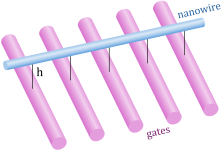


Each gate has its own position, radius, screening length, and voltage, which are
stored in instances of the `GateParameters` dataclass.

Note that the voltage given by `GateParameters.peak`, is the peak voltage
induced by the gate along the nanowire (the maximum of V(x) in the absence of
other gates), **not the voltage of the gate itself**.

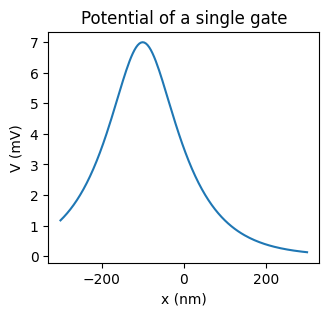

In [3]:
# Get one of the gates from the sample physics parameters 
gate_params = phys.gates[1]

# Calculate the potential along the nanowire due to a single gate
x = phys.x
V_gate = simulation.calc_V_gate(gate_params, x, 0, 0)

# Plot the result
fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(x, V_gate)
ax.set_xlabel("x (nm)")
ax.set_ylabel("V (mV)")
ax.set_title("Potential of a single gate");

When multiple gates are in close proximity, the charge from one gate can induce
additional charges on the other gates. QDFlow attempts to correct for this
effect, assuming that the induced charges are cylidrically symmetric, allowing
us to replace the gate voltage with an effective voltage which includes the
induced charges.

In [4]:
# Get list of gate voltages from the sample physics parameters 
gates = phys.gates
gate_voltages = np.array([gate.peak for gate in gates])
print("Gate voltages:", gate_voltages)

# Calculate correction matrix to account for induced charges
gate_matrix = simulation.calc_effective_peak_matrix(gates)

# Calculate effective gate voltages due to induced charges
effective_voltages = np.dot(gate_matrix, gate_voltages)
print("Effective voltages:", effective_voltages)

Gate voltages: [-7.   7.  -5.   7.5 -7. ]
Effective voltages: [-8.76084453 10.09547469 -8.3128789  10.64644697 -8.86626613]


When calculating the potential via `calc_V()`, this will be calculated automatically.

If you wish to not take into account induced charges, you can use the keyword arg
`effective_peak_matrix=np.identity(len(gates))`. This will essentially treat
the gates as a nonconducting static line charge.

`phys.q` is the sign of the charges (-1 for electrons, +1 for holes). From here
on, we shall plot the potential energy q * V, rather than V(x) directly.

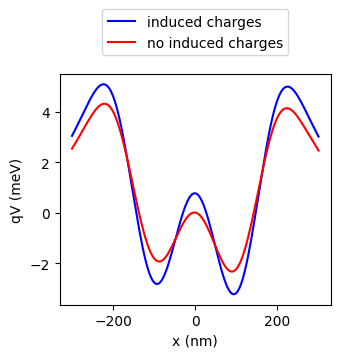

In [5]:
# Calculate V(x) from the gates
gates = phys.gates
x = phys.x
V = simulation.calc_V(gates, x, 0, 0)

# Calculate V(x) assuming no induced charges
V_no_induced_charge = simulation.calc_V(gates, x, 0, 0,
                      effective_peak_matrix=np.identity(len(gates)))

q = phys.q # Get the sign of the charges

# Plot the results
fig, ax = plt.subplots(figsize=(3.5,3))
tutorial_helper.plot_potential(fig, ax, x, q*V, color="blue")
tutorial_helper.plot_potential(fig, ax, x, q*V_no_induced_charge, color="red")
ax.legend(["induced charges","no induced charges"], loc="lower center", bbox_to_anchor=(0.5, 1.05))

Now we must also calculate the Coulomb interaction matrix K(x, x').
Alternatetively, K(x, x') can be supplied directly as part of the `PhysicsParameters`
dataclass, in which case this next step is skipped.

By default, K(x, x') is calculated using the formula:

$K(x, x') = \frac{K_0}{\sqrt{(x-x')^2 + \sigma^2}}$.

Here $\sigma$ is a softening parameter which prevents K(x, x') from blowing up
when (x - x') is small or zero. This numerical issue occurs because our
simulation is 1D, which assumes an intinitessimally thin nanowire. In reality,
however, the nanowire has some finite width, which prevents K(x, x') from blowing
up. Thus, $\sigma$ should be chosen to be on the order of the width of the nanowire.

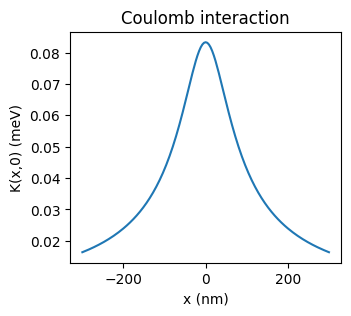

In [6]:
# Get sample physics parameters
x = phys.x
K_0 = phys.K_0
sigma = phys.sigma

# Calculate the Coulomb interaction matrix
K_mat = simulation.calc_K_mat(x, K_0, sigma)

# Plot the result
fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(x, K_mat[:, len(x)//2])
ax.set_xlabel("x (nm)")
ax.set_ylabel("K(x,0) (meV)")
ax.set_title("Coulomb interaction");